# uep239 Final project: Where the Book Worms Go
## By Kees Schipper

### Start by loading in all libraries in one cell. 
This cell is going to be adjusted while writing the notebook based on what packages I might need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import rasterio
from rasterio.plot import show
from rasterio import features

import richdem as rd
from scipy import ndimage
from shapely.geometry import box
from rasterstats import zonal_stats
import os

# finally, check working directory to see where we are in our file structure
os.getcwd()

'C:\\Users\\keess\\OneDrive\\Documents\\Tufts Friedman School\\Semester 4\\Geospatial Programming with Python\\uep239FinalProj\\notebooks'

### Change current working directory to the data folder for easier reading of files

In [2]:
os.chdir("../Data")

## Part 1: Reading in our data

### 1a: Tabular Data

In [175]:
# tabular data
AgeSex = pd.read_csv("AgeACS.csv", header = 0, skiprows=[1])
Edu = pd.read_csv("EduAttainmentACS.csv", header = 0, skiprows = [1])

# select only columns that have data of interest to you, plus columns containing primary keys
AgeSex_cols = AgeSex[['GEO_ID', 'NAME', 'S0101_C01_022E', 'S0101_C01_026E', 'S0101_C02_026E']].copy()
Edu_cols = Edu[['GEO_ID', 'NAME', 'S1401_C03_010E', 'S1401_C04_010E']].copy()

# rename columns to be more intuitive
AgeSex_cols = AgeSex_cols.rename(columns = {"S0101_C01_022E":"popUnder18", "S0101_C01_026E":"popOver18", "S0101_C02_026E":"pctOver18"})
Edu_cols = Edu_cols.rename(columns = {"S1401_C03_010E":"popInCollege", "S1401_C04_010E":"pctInCollege"})

print(AgeSex_cols.columns)
print(Edu_cols.columns)

Index(['GEO_ID', 'NAME', 'popUnder18', 'popOver18', 'pctOver18'], dtype='object')
Index(['GEO_ID', 'NAME', 'popInCollege', 'pctInCollege'], dtype='object')


#### Let's also look at some basic descriptions of our data to see what we're dealing with

In [183]:
AgeSex_cols.describe()

,popUnder18,popOver18,pctOver18
count,537.000000,537.000000,537.000000
mean,2553.556797,10203.417132,81.016201
std,2702.400435,10291.627226,9.185791
min,0.000000,0.000000,0.000000
25%,404.000000,2141.000000,77.300000
50%,1656.000000,6988.000000,80.300000
75%,3771.000000,14533.000000,84.700000
max,16734.000000,51217.000000,100.000000


In [184]:
AgeSex_cols.pctOver18.unique()

# remove the non-numeric entries in the column
AgeSex_cols.pctOver18 = AgeSex_cols.pctOver18.str.replace(pat = '-', repl = '0.0', regex = False)
# convert cleaned series into a float series
AgeSex_cols.pctOver18 = AgeSex_cols.pctOver18.astype("float")

# check that everything works as it should.

AgeSex_cols.describe()

AttributeError: Can only use .str accessor with string values!

In [185]:
Edu_cols.describe()

,popInCollege
count,537.000000
mean,519.957169
std,859.161892
min,0.000000
25%,74.000000
50%,282.000000
75%,600.000000
max,10248.000000


Interesting...it seems like pctInCollege is not a numeric object. Let's explore why that is

In [186]:
print(Edu_cols.dtypes) # pctInCollege is an object, likely meaning there is some type of character string preventing it from being numeric
print(Edu_cols.pctInCollege.unique())

GEO_ID          object
NAME            object
popInCollege     int64
pctInCollege    object
dtype: object
['48.8' '75.7' '90.7' '72.1' '62.8' '37.8' '0.0' '40.3' '75.3' '100.0'
 '60.4' '72.3' '72.4' '65.5' '70.5' '66.1' '-' '56.1' '30.6' '60.0' '64.9'
 '74.7' '77.2' '61.3' '78.3' '77.0' '81.1' '87.8' '62.3' '66.5' '41.4'
 '35.4' '56.0' '64.3' '48.5' '82.4' '64.4' '36.8' '73.4' '87.3' '90.1'
 '78.1' '75.5' '81.3' '90.4' '61.5' '72.8' '40.0' '61.1' '57.6' '50.0'
 '81.6' '85.7' '24.6' '71.9' '79.8' '63.9' '44.4' '91.0' '63.8' '83.6'
 '63.3' '62.7' '93.4' '63.7' '21.5' '77.1' '58.8' '35.8' '72.2' '27.8'
 '76.2' '56.3' '65.4' '37.0' '57.1' '19.6' '55.6' '24.2' '82.8' '68.8'
 '86.7' '91.1' '46.9' '66.7' '47.2' '84.2' '87.1' '47.7' '85.0' '85.2'
 '63.2' '46.0' '72.7' '68.4' '76.6' '97.7' '50.8' '71.8' '57.9' '47.9'
 '43.5' '84.5' '58.6' '70.7' '67.3' '71.0' '78.7' '67.4' '47.3' '84.3'
 '81.0' '91.8' '90.2' '67.2' '65.1' '34.9' '78.5' '61.6' '69.4' '83.5'
 '47.6' '54.6' '88.4' '54.9' '49.9' '7

In the unique values, we see that there is one entry that is a `'-'` instead of a number, which is preventing python from interpreting this series as a float. Let's remove that string value and change it to 0.0, then we can convert the series to a float.

In [187]:
# replace the problematic string
Edu_cols.pctInCollege = Edu_cols.pctInCollege.str.replace(pat = '-', repl = '0.0', regex = False)

# change the series into a float data type
Edu_cols.pctInCollege = Edu_cols.pctInCollege.astype("float")


In [188]:
# check the dtype and summary of the dataset
print(Edu_cols.pctInCollege.dtype)
Edu_cols.describe()
# we now have a dataset that we can work with!!

float64


,popInCollege,pctInCollege
count,537.000000,537.000000
mean,519.957169,55.576536
std,859.161892,25.895560
min,0.000000,0.000000
25%,74.000000,40.700000
50%,282.000000,60.300000
75%,600.000000,74.400000
max,10248.000000,100.000000


### Part 1b: Reading in Shapefiles

In [189]:
# read in files with intuitive names
Libs = gpd.read_file("LIBRARIES_PT.shp")
mbta_node = gpd.read_file("MBTA_NODE.shp")
MPO_Bounds = gpd.read_file("MPO_Boundaries.shp")
ZCTA = gpd.read_file("tl_2010_25_zcta510.shp")

See what the CRS values are for each of our shapefiles

In [190]:
print(Libs.crs)
print(mbta_node.crs)
print(MPO_Bounds.crs)
print(ZCTA.crs)
# looks like we have 3 different CRS values for our shapefiles, which is an easy thing to fix.

epsg:26986
epsg:26986
epsg:3857
epsg:4269


In [191]:
MPO_Bounds.to_crs(epsg = "26986", inplace=True)
ZCTA.to_crs(epsg = "26986", inplace = True)
print(MPO_Bounds.crs)
print(ZCTA.crs)

epsg:26986
epsg:26986


### Let's try overlaying the maps to see that they all line up

<AxesSubplot:>

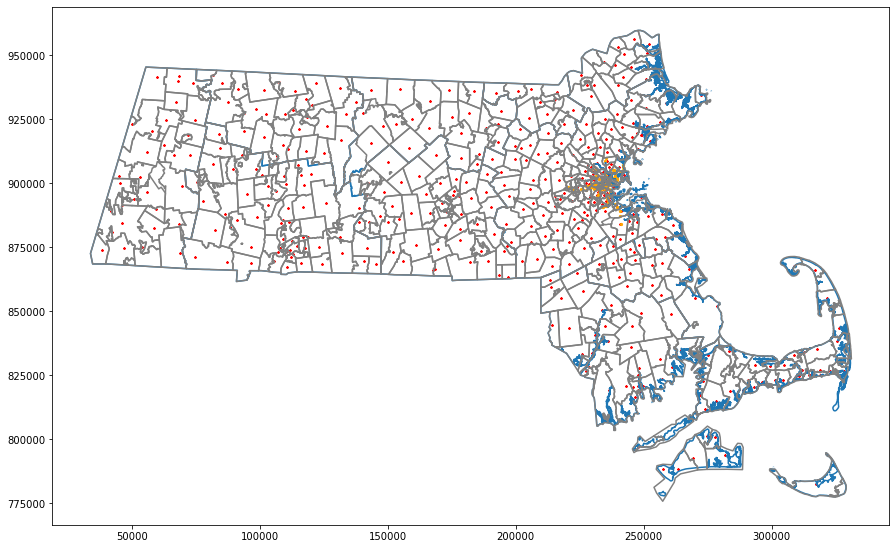

In [192]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
MPO_Bounds.boundary.plot(ax = ax)
ZCTA.boundary.plot(ax = ax, color = "grey")
Libs.plot(ax = ax, color = "red", marker = "*", markersize = 4)
mbta_node.plot(ax = ax, color = "orange", markersize = 5)

So far, it looks like everything lines up pretty nicely, but we should limit our study area to just the boston metropolitan area...We need to find which region in MPO_Bounds corresponds to Boston, and then clip all of our shapefiles to that region.

['Berkshire' 'Cape Cod' 'Central Massachusetts' 'Franklin' 'Montachusett'
 "Martha's Vineyard" 'Merrimack Valley' 'Northern Middlesex' 'Nantucket'
 'Pioneer Valley' 'Boston Region' 'Old Colony'
 'Southeastern Massachusetts']


,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
10,12,Boston Region,None,1970-01-01,DINOCCOD,2018-04-18,{3801574E-3CF1-4344-BE7C-8B2FBA431DD8},3.524379e+09,1.665026e+06,"MULTIPOLYGON (((261954.246 925125.468, 261961...."


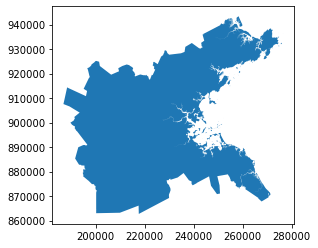

In [193]:
print(MPO_Bounds.MPO.unique())
Bos_Bounds = MPO_Bounds[MPO_Bounds.MPO == 'Boston Region'].copy()
Bos_Bounds.plot()
Bos_Bounds

Now we need to clip all of our other data (`ZCTA`, `Libs`, `mbta_node`) to the extent of Bos_Bounds. We can do this using the `gpd.clip()` function

<AxesSubplot:>

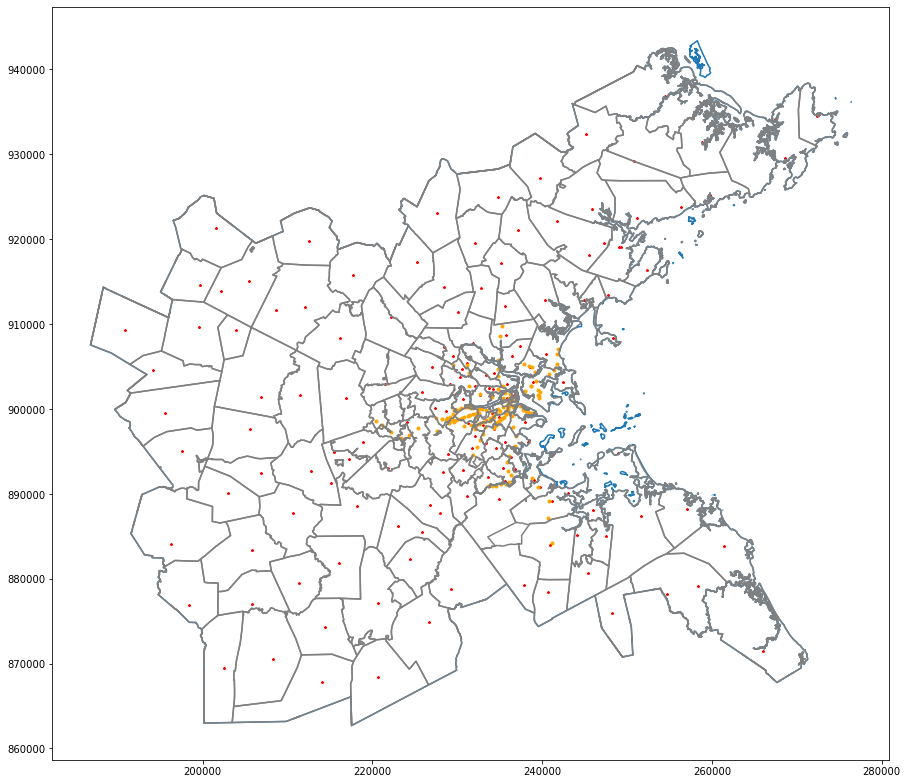

In [50]:
ZCTA_clip = gpd.clip(ZCTA, Bos_Bounds)
Libs_clip = gpd.clip(Libs, Bos_Bounds)
mbta_clip = gpd.clip(mbta_node, Bos_Bounds)

# check that the clip was effective
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
Bos_Bounds.boundary.plot(ax = ax)
ZCTA_clip.boundary.plot(ax = ax, color = "grey")
Libs_clip.plot(ax = ax, color = "red", markersize = 5, marker = "*")
mbta_clip.plot(ax = ax, color = "orange", markersize = 9)

At this point in our analysis, we only really need the Bos_bounds vector data to clip other rasters. All the data for our vulnerability analyses are in our other data sets

### 1c: Read in Raster data

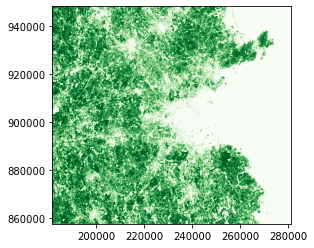

(30.0, 30.0) 
 EPSG:6491 
 None 
 BoundingBox(left=181770.0, bottom=857670.0, right=281430.0, top=948390.0) 
 (3024, 3322)


In [75]:
with rasterio.open("NLCD_2016_Tree_Canopy_Boston.tif") as treecover:
    trees = treecover.read(1)
    transform = treecover.transform
    res = treecover.res
    crs = treecover.crs
    nodata = treecover.nodata
    bounds = treecover.bounds
    shape = treecover.shape

# get rid of no data values (255 doesn't represent any data, and gets in the way of tree canopy calculations)
trees[trees == 255] = 0    

show(trees, transform = transform, cmap = "Greens")
print(res, "\n", crs, "\n", nodata, "\n", bounds, "\n", shape)

## Part 2: Rasterizing Point Data

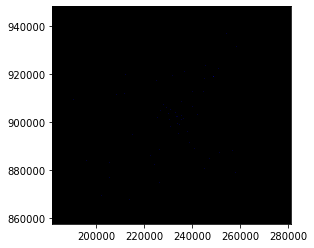

<AxesSubplot:>

In [83]:
# First, we need to turn our point features into raster features
mbta_ras = features.rasterize(mbta_clip['geometry'], out_shape = shape, fill = 1, transform = transform, default_value = 0)
Libs_ras = features.rasterize(Libs_clip['geometry'], out_shape = shape, fill = 1, transform = transform, default_value = 0)

<AxesSubplot:>

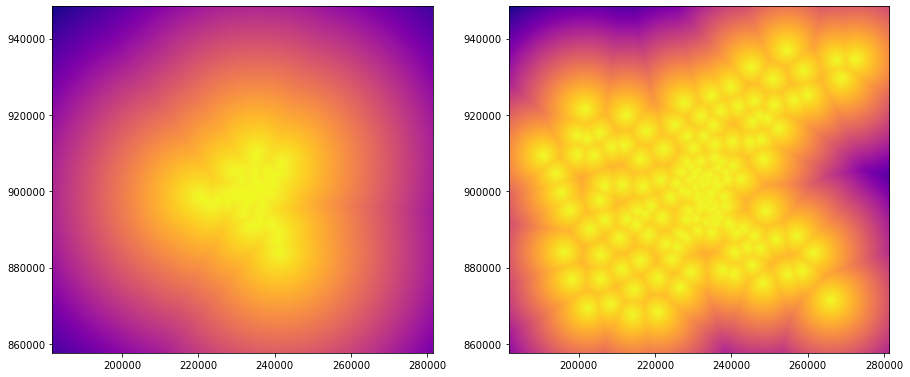

In [98]:
# now we can make a distance matrix, and set the resolution to be equivalent to that of the tree cover matrix
mbta_dist = ndimage.distance_transform_edt(mbta_ras) * res[0]
Lib_dist = ndimage.distance_transform_edt(Libs_ras) * res[0]

# let's see how our distance rasters look with some pretty colors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 20))

show(mbta_dist, transform = transform, ax = ax1, cmap = 'plasma_r')
show(Lib_dist, transform = transform, ax = ax2, cmap = 'plasma_r')

Let's create a 5-level reclassification structure for both MBTA distance and Library distances

<AxesSubplot:>

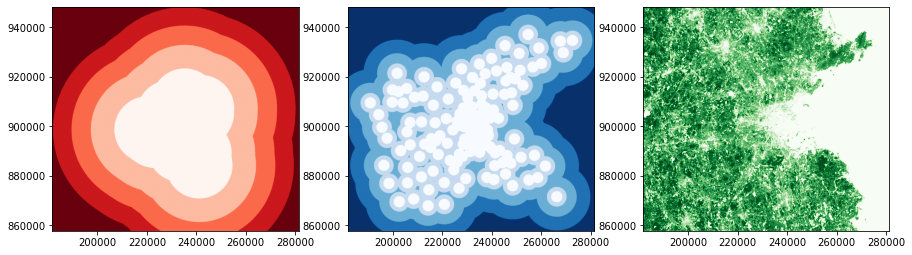

In [128]:
def classify5Quants(raster, lowdist = "good"):
    quants = np.quantile(raster, q = [.20, .40, .60, .80])
    
    output = np.full(shape = raster.shape, fill_value = np.NaN)
    
    if lowdist == "good":
        output[raster <= quants[0]] = 1
        output[(raster > quants[0]) & (raster <= quants[1])] = 2
        output[(raster > quants[1]) & (raster <= quants[2])] = 3
        output[(raster > quants[2]) & (raster <= quants[3])] = 4
        output[raster > quants[3]] = 5
        
        return output
        
    elif lowdist == "bad":
        output[raster <= quants[0]] = 5
        output[(raster > quants[0]) & (raster <= quants[1])] = 4
        output[(raster > quants[1]) & (raster <= quants[2])] = 3
        output[(raster > quants[2]) & (raster <= quants[3])] = 2
        output[raster > quants[3]] = 1
        
        return output
        
    else:
        raise Exception("lowdist must either be 'good' or 'bad', meaning that in your scoring algorithms, low distances are either 'good' or 'bad' for your scoring")
        
mbta_reclass = classify5Quants(raster = mbta_dist)
Lib_reclass = classify5Quants(raster = Lib_dist)
trees_reclass = classify5Quants(raster = trees)

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 25))

show(mbta_reclass, transform = transform, cmap = 'Reds', ax = ax1)
show(Lib_reclass, transform = transform, cmap = 'Blues', ax = ax2)
show(trees_reclass, transform = transform, cmap = 'Greens', ax = ax3)

As you can see by the figure above, all of our data are on the same scale, and could be added together to form a weight raster. However, I still want to look at a couple variables, such as the population of zipcode areas over 18 years and the population of individuals enrolled in college/graduate school in a public university.

Currently, we have complete rasters on three of our 6 desired factors
1. Proximity to public Libraries
2. Proximity to MBTA nodes
3. Different levels of tree canopy 

Now, we need to combine tabular data from our read-in csv files, and join them to a GeoDataFrame

## Part 3: Incorporating tabular data

In [150]:
print(Edu_cols.columns)
print(AgeSex_cols.columns)
AgeEdu = Edu_cols.merge(AgeSex_cols, how = "outer", on = ['GEO_ID', 'NAME'])
AgeEdu[['GEO_ID1', 'ZCTA5CE10']] = AgeEdu.GEO_ID.str.split(pat = "US", n = 1, expand = True)

Index(['GEO_ID', 'NAME', 'popInCollege', 'pctInCollege'], dtype='object')
Index(['GEO_ID', 'NAME', 'popUnder18', 'popOver18'], dtype='object')


In [151]:
ZCTA_clip.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
17,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"MULTIPOLYGON (((243877.753 913824.638, 243872...."
18,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245700.484 914778.700, 245667.412 91..."
20,25,01930,2501930,B5,G6350,S,67847425,13972397,+42.6199100,-070.6818235,N,"MULTIPOLYGON (((261745.067 931625.267, 261822...."
21,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"MULTIPOLYGON (((250787.714 926889.372, 251155...."
22,25,01921,2501921,B5,G6350,S,61010486,2188501,+42.6831083,-071.0183302,N,"MULTIPOLYGON (((245193.985 936821.773, 244097...."


In [149]:
AgeEdu.head()

,GEO_ID,NAME,popInCollege,pctInCollege,popUnder18,popOver18,GEO_ID1,ZCTA5CE10
0,8600000US01001,ZCTA5 01001,520,48.8,3167,14145,8600000,01001
1,8600000US01002,ZCTA5 01002,9305,75.7,3768,26246,8600000,01002
2,8600000US01003,ZCTA5 01003,10248,90.7,139,11218,8600000,01003
3,8600000US01005,ZCTA5 01005,245,72.1,1005,4123,8600000,01005
4,8600000US01007,ZCTA5 01007,677,62.8,3399,11606,8600000,01007


KeyError: 'pctOver18'

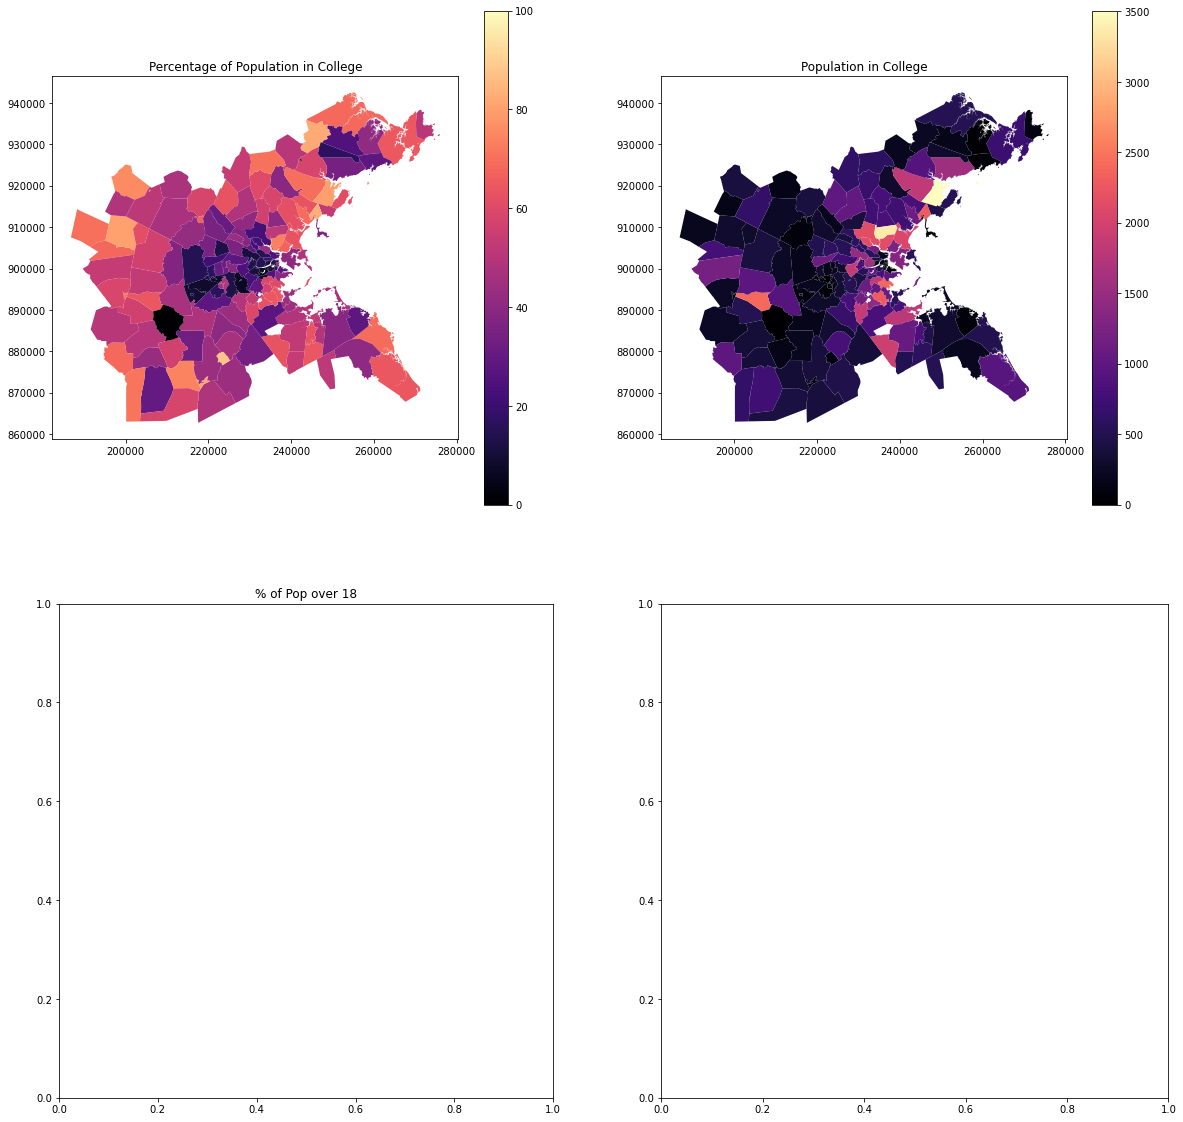

In [182]:
ZCTA_AgeEdu = ZCTA_clip.merge(AgeEdu, on = 'ZCTA5CE10', how = 'left')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 20))
ax1.set_title("Percentage of Population in College")
ZCTA_AgeEdu.plot(column = 'pctInCollege', cmap = 'magma', legend = True, ax = ax1)
ax2.set_title("Population in College")
ZCTA_AgeEdu.plot(column = 'popInCollege', cmap = 'magma', legend = True, ax = ax2)
ax3.set_title("% of Pop over 18")
ZCTA_AgeEdu.plot(column = 'pctOver18', cmap = 'magma', legend = True, ax = ax3)
ax4.set_title("Population over 18")
ZCTA_AgeEdu.plot(column = 'popOver18', cmap = 'magma', legend = True, ax = ax4)